In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfd = tfp.distributions
np.random.seed(1234)

sns.set(style="white")

In [2]:
print("The GPflow version is {0}".format(gpflow.__version__))
print("The tensorflow version is {0}".format(tf.__version__))
print("The tensorflow-probability version is {0}".format(tfp.__version__))

The GPflow version is 2.1.0
The tensorflow version is 2.2.0
The tensorflow-probability version is 0.10.1


In [3]:
gpflow.config.set_default_summary_fmt("notebook")

In [4]:
def plot_prediction(X, Y, model, X_test=None, Y_test=None, num_samples=20):
    fig, ax = plt.subplots(1, figsize=(15, 4))
    
    Xnew = np.linspace(X.min(axis=0) - 0.5, X.max(axis=0) + 0.5, 100)
    Ypred = model.predict_f_samples(Xnew, full_cov=True, num_samples=num_samples)
    mean, var = model.predict_f(Xnew)
    
    ax.plot(Xnew.flatten(), np.squeeze(Ypred).T, "C1", alpha=0.2)
    ax.plot(Xnew.flatten(), mean, "-", c="C0")
    
    lo = (mean - 2 * tf.sqrt(var)).numpy()
    hi = (mean + 2 * tf.sqrt(var)).numpy()
    ax.fill_between(Xnew.flatten(), lo.flatten(), hi.flatten(), alpha=0.3)
    ax.plot(X, Y, "o", c="C2", alpha=0.7, label="train")
    if (X_test is not None) and (Y_test is not None):
        ax.plot(X_test, Y_test, "o", c="C3", alpha=0.7, label="test")
        ax.legend()

In [5]:
def plot_kernel_sample(k, xmin=0, xmax=3, other=0):
    f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True)
    
    xx = np.linspace(xmin, xmax, 300)[:, None]
    K = k(xx)
    axes[0].plot(xx, np.random.multivariate_normal(np.zeros(300), K, 5).T)
    axes[0].set_title("Samples " + k.__class__.__name__)
    
    axes[1].plot(xx, k(xx, np.zeros((1, 1)) + other))
    axes[1].set_title(k.__class__.__name__ + " k(x, %.1f)" % other)

## Load Datasets US

The second data come from microsoft [link](https://github.com/microsoft/Bing-COVID-19-Data). This set includes recovered, so we can calculate the number of infected, recovered and susceptible as a function of time. 

#### Mobility

In [6]:
mobility_data = pd.read_csv(
    "../Data/Google/Global_Mobility_Report.csv", 
    encoding="ISO-8859-1", 
    parse_dates=["date"]
)

/Users/N547113/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Cases

In [7]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv(
    "../Data/Microsoft/COVID_CASES.csv", 
    encoding="ISO-8859-1",
    parse_dates=["Updated"]
)
ms_us_covid = ms_covid[(ms_covid["Country_Region"]=="United States") & (ms_covid["AdminRegion1"].isnull())]
ms_us_covid = ms_us_covid.loc[:,["Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]
ms_us_covid.reset_index(drop=True, inplace=True)

In [8]:
# Create the 3 categories S, I, R for US data (UK does not include R)
ms_us_covid.fillna(0, inplace=True)
ms_us_covid["I"] = ms_us_covid["Confirmed"] - ms_us_covid["Deaths"] - ms_us_covid["Recovered"]

ms_us_covid["S"] = 328000000 - ms_us_covid["I"]

ms_us_covid["index"] = ms_us_covid["Updated"].dt.dayofyear

In [9]:
# drop the last value because it looks wrong
ms_us_covid = ms_us_covid[:-1].copy()

In [10]:
# US
ms_us_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Updated          216 non-null    datetime64[ns]
 1   Confirmed        216 non-null    int64         
 2   ConfirmedChange  216 non-null    float64       
 3   Deaths           216 non-null    float64       
 4   Recovered        216 non-null    float64       
 5   I                216 non-null    float64       
 6   S                216 non-null    float64       
 7   index            216 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 13.6 KB


In [11]:
ms_us_covid.head()

,Updated,Confirmed,ConfirmedChange,Deaths,Recovered,I,S,index
0,2020-01-21,1,0.0,0.0,0.0,1.0,327999999.0,21
1,2020-01-23,1,0.0,0.0,0.0,1.0,327999999.0,23
2,2020-01-24,2,1.0,0.0,0.0,2.0,327999998.0,24
3,2020-01-25,3,1.0,0.0,0.0,3.0,327999997.0,25
4,2020-01-26,5,2.0,0.0,0.0,5.0,327999995.0,26


In [12]:
mobility_data.dtypes

country_region_code                                           object
country_region                                                object
sub_region_1                                                  object
sub_region_2                                                  object
metro_area                                                    object
iso_3166_2_code                                               object
census_fips_code                                             float64
date                                                  datetime64[ns]
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
dtype: object

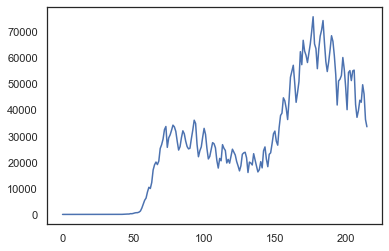

In [13]:
plt.plot(ms_us_covid["ConfirmedChange"])

# Explore the Google Mobility Dataset

From the Google Mobility data we keep only the general UK cases. We do not go down to LAD (lower administrative level).

We do the same for the US cases

In [14]:
mobility_data_us = mobility_data[
    (mobility_data["country_region"]=="United States") & (mobility_data["sub_region_1"].isnull())
]
mobility_data_us = mobility_data_us.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
mobility_data_us.columns

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

In [15]:
# transform the data to pct change
mobility_data_us.iloc[:,1:] = mobility_data_us.iloc[:,1:].apply(lambda x: x/100 + 1)

In [16]:
mobility_data_us.head()

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,1.06,1.02,1.15,1.03,1.02,0.99
1,2020-02-16,1.07,1.01,1.16,1.02,1.00,0.99
2,2020-02-17,1.06,1.00,1.28,0.91,0.76,1.05
3,2020-02-18,1.00,0.99,1.06,1.01,1.00,1.01
4,2020-02-19,1.02,1.00,1.08,1.01,1.01,1.00


Merge the Google mobility data to HOME, WORK, and OTHER, with the OTHER to include parks, transit, retail and grocery. 

In [17]:
data_us = pd.DataFrame({
    "date": mobility_data_us["date"],
    "HOME": mobility_data_us['residential_percent_change_from_baseline'],
    "WORK": mobility_data_us['workplaces_percent_change_from_baseline'],
    "RECREATIONAL": mobility_data_us['retail_and_recreation_percent_change_from_baseline'],
    "OTHER": mobility_data_us.iloc[:,2:5].mean(axis=1)
})

In [18]:
data_us.head()

,date,HOME,WORK,RECREATIONAL,OTHER
0,2020-02-15,0.99,1.02,1.06,1.066667
1,2020-02-16,0.99,1.00,1.07,1.063333
2,2020-02-17,1.05,0.76,1.06,1.063333
3,2020-02-18,1.01,1.00,1.00,1.020000
4,2020-02-19,1.00,1.01,1.02,1.030000


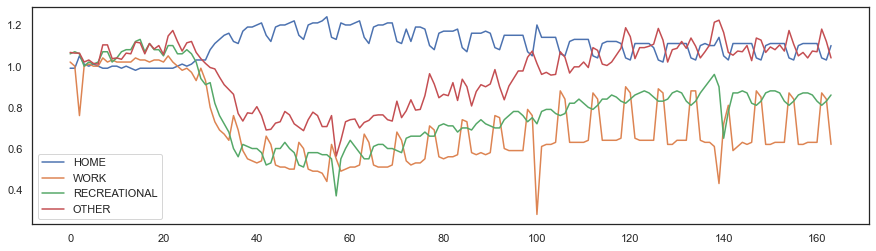

In [19]:
data_us.drop(columns=["date"]).plot(figsize=(15, 4))

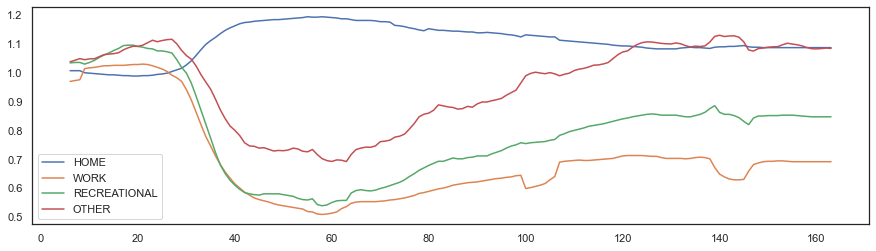

In [20]:
data_us.rolling(7).mean().plot(figsize=(15, 4))

# Visually explore the dataset

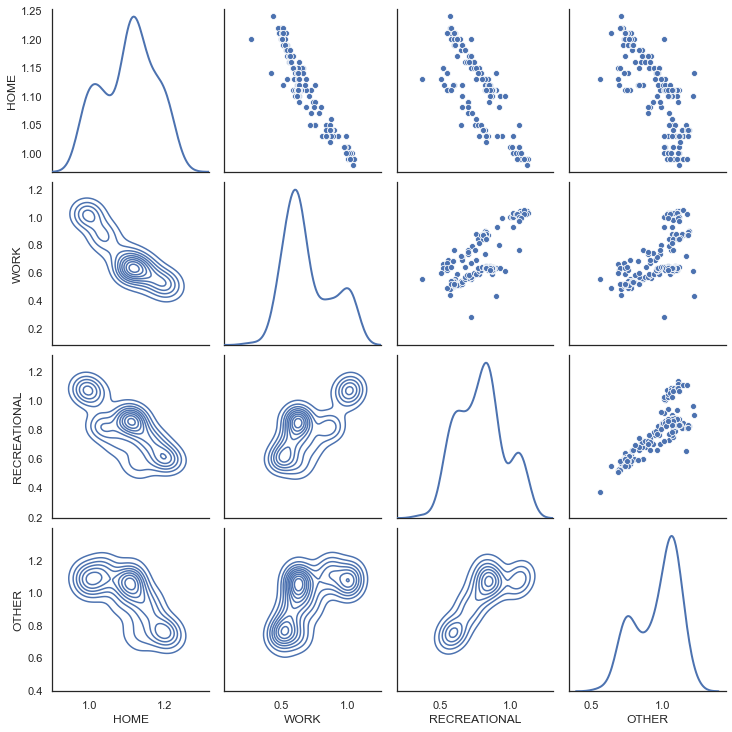

In [21]:
g = sns.PairGrid(data_us, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)

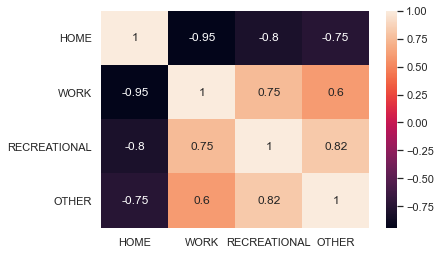

In [22]:
sns.heatmap(data_us.corr(), annot=True)

# Merge the Datasets

In [23]:
ms_us_covid.dtypes

Updated            datetime64[ns]
Confirmed                   int64
ConfirmedChange           float64
Deaths                    float64
Recovered                 float64
I                         float64
S                         float64
index                       int64
dtype: object

In [24]:
data_us.dtypes

date            datetime64[ns]
HOME                   float64
WORK                   float64
RECREATIONAL           float64
OTHER                  float64
dtype: object

Merge the two datasets, the MS covid US and the Google mobility by date

In [25]:
final_data_us = ms_us_covid.set_index("Updated").merge(
    data_us.set_index("date"), how='left', left_index=True, right_index=True
).reset_index()

In [26]:
final_data_us.dropna(inplace=True)

In [27]:
final_data_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 12 to 198
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Updated          139 non-null    datetime64[ns]
 1   Confirmed        139 non-null    int64         
 2   ConfirmedChange  139 non-null    float64       
 3   Deaths           139 non-null    float64       
 4   Recovered        139 non-null    float64       
 5   I                139 non-null    float64       
 6   S                139 non-null    float64       
 7   index            139 non-null    int64         
 8   HOME             139 non-null    float64       
 9   WORK             139 non-null    float64       
 10  RECREATIONAL     139 non-null    float64       
 11  OTHER            139 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 14.1 KB


Merge the two datasets, UK mobility and ONS covid

# Include Mixing Matrix Information

In [28]:
# Create a combination of mixing matrices the same way they do in literature. 
# Fill NA values with 0

C_HOME = pd.read_csv("../Data/BBC/HOME.csv", index_col=0)

C_WORK = pd.read_csv("../Data/BBC/WORK.csv", index_col=0)

C_OTHER = pd.read_csv("../Data/BBC/OTHER.csv", index_col=0)

C = C_HOME + C_WORK + C_OTHER

C.fillna(0, inplace=True)

# Variational Bayesian non-parametric inference for infectious disease models

In this approach we follow Hensman and Kypraios paper. 

1. $\lambda(t) = \exp(f(t))$; the GP model depends only on time
2. $\lambda(t) = \beta(t)S(t)I(t)$ with $\beta(t)$ = exp($f$(t)); the GP model allows the person to person infenction to be non-constant and time-varying
3. $\lambda(t) = \exp(f(S(t)I(t)))$; the GP model is a function of the product S(t)I(t)

We use US data

In [29]:
final_data_us["S*I"] = final_data_us["S"]*final_data_us["I"]

In [30]:
final_data_us["Confirmed"] = final_data_us["Confirmed"].astype("float64")
final_data_us["index"] = final_data_us["index"].astype("float64")
final_data_us["index"] -= final_data_us["index"].values[0] - 1.
final_data_us.set_index("index", drop=False, inplace=True)
final_data_us.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 139 entries, 1.0 to 187.0
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Updated          139 non-null    datetime64[ns]
 1   Confirmed        139 non-null    float64       
 2   ConfirmedChange  139 non-null    float64       
 3   Deaths           139 non-null    float64       
 4   Recovered        139 non-null    float64       
 5   I                139 non-null    float64       
 6   S                139 non-null    float64       
 7   index            139 non-null    float64       
 8   HOME             139 non-null    float64       
 9   WORK             139 non-null    float64       
 10  RECREATIONAL     139 non-null    float64       
 11  OTHER            139 non-null    float64       
 12  S*I              139 non-null    float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 15.2 KB


In [31]:
final_data_us.shape

(139, 13)

In [32]:
final_data_us.head()

,Updated,Confirmed,ConfirmedChange,Deaths,Recovered,I,S,index,HOME,WORK,RECREATIONAL,OTHER,S*I
index,,,,,,,,,,,,,
1.0,2020-02-03,11.0,0.0,0.0,0.0,11.0,327999989.0,1.0,0.99,1.03,1.07,1.060000,3.608000e+09
2.0,2020-02-04,11.0,0.0,0.0,0.0,11.0,327999989.0,2.0,1.21,0.50,0.60,0.763333,3.608000e+09
3.0,2020-02-05,12.0,1.0,0.0,1.0,11.0,327999989.0,3.0,1.10,0.71,0.66,0.963333,3.608000e+09
4.0,2020-02-06,12.0,0.0,1.0,0.0,11.0,327999989.0,4.0,1.13,0.63,0.82,0.996667,3.608000e+09
5.0,2020-02-07,12.0,0.0,1.0,3.0,8.0,327999992.0,5.0,1.10,0.61,0.96,1.213333,2.624000e+09


### Model 1: $\lambda(t) = \exp(f(t))$

In [33]:
y = final_data_us[["ConfirmedChange"]].to_numpy()
X = final_data_us[["index"]].to_numpy()

y_scaler = preprocessing.StandardScaler().fit(y)
y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X)
X = x_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

y_train = y_train
y_test = y_test

X_train = X_train
X_test = X_test

In [34]:
MTRN = gpflow.kernels.Matern32()
k_mtrn = MTRN

print_summary(k_mtrn)

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k_slr = SE*LIN*RQ

print_summary(k_slr)

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


**Likelihood**: The likelihood of the observed data is Poisson distribution

#### Poisson likelihood

In [35]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Poisson(), 
    kernel=k_slr
)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, variables=m.trainable_variables, options=dict(maxiter=20000))
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.3038782891675758
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.1485197383703996
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.303878289167554
VGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.3038782891675735
VGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1.196308098452065
VGP.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1.0063205151026295
VGP.q_mu,Parameter,Identity,,True,"(111, 1)",float64,[[-1.20250465e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 111, 111)",float64,"[[[-7.04774545e-01, 0.00000000e+00, 0.00000000e+00..."


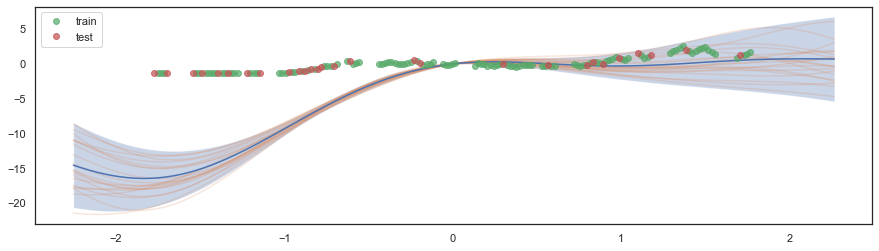

In [36]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [37]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.9663648343257992, 'test', 1.0557860122179135)

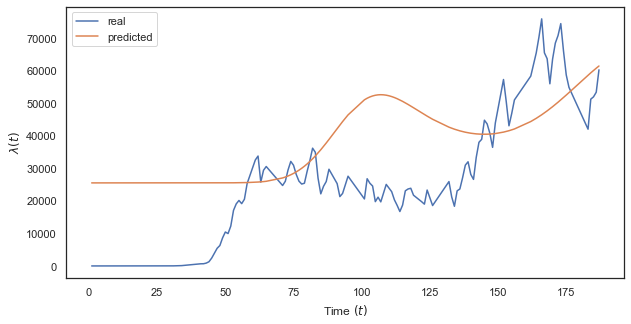

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_us[["index"]].to_numpy().reshape(-1, 1)
y_1 = y_scaler.inverse_transform(np.exp(m.predict_f(X)[0].numpy()))

_ = plt.plot(final_data_us["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_1, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

#### Gaussian likelihood

##### Kernel SE * LIN * RQ

In [39]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k_slr
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.8626332427616182
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.529903205891767
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.862633242761614
VGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.8626332427615914
VGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,0.13798606678298778
VGP.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,0.029577658172099584
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.015458484436552738
VGP.q_mu,Parameter,Identity,,False,"(111, 1)",float64,[[1.13604740e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 111, 111)",float64,"[[[1.04989831e-01, 0.00000000e+00, 0.00000000e+00..."


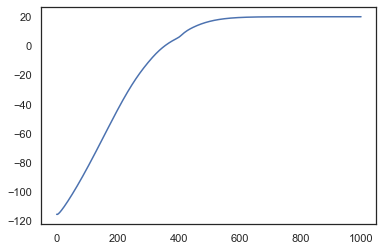

In [40]:
# ELBO
plt.plot(logf)

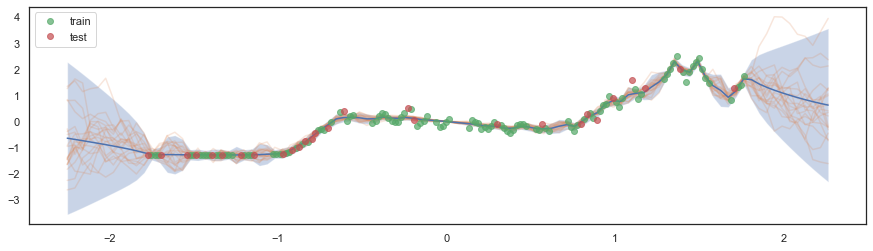

In [41]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [42]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.005754943890918458, 'test', 0.014289484158897322)

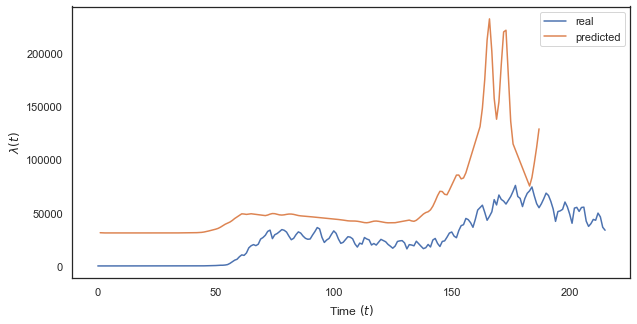

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_us[["index"]].to_numpy().reshape(-1, 1)
y_2 = y_scaler.inverse_transform(np.exp(m.predict_f(X)[0].numpy()))

_ = plt.plot(ms_us_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_2, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

##### Kernel Matern32

In [44]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k_mtrn
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.069356534858794
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.6711159545608972
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.030801247547953103
VGP.q_mu,Parameter,Identity,,False,"(111, 1)",float64,[[1.14581775e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 111, 111)",float64,"[[[8.51231766e-02, 0.00000000e+00, 0.00000000e+00..."


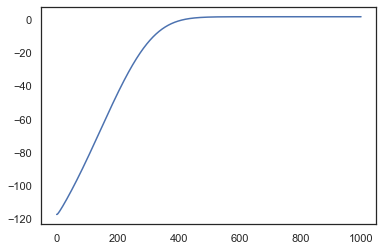

In [45]:
# ELBO
plt.plot(logf)

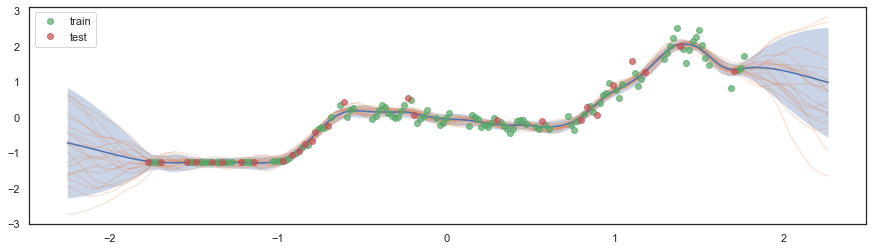

In [46]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [47]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.0056330282976635605, 'test', 0.006709001343898979)

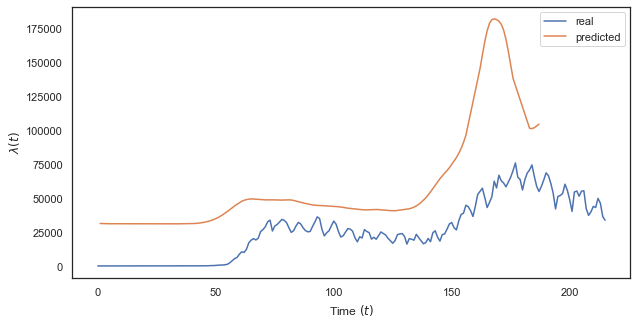

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_us[["index"]].to_numpy().reshape(-1, 1)
y_3 = y_scaler.inverse_transform(np.exp(m.predict_f(X)[0].numpy()))

_ = plt.plot(ms_us_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_3, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

#### Comments

The results from M1 $\lambda(t)$ = exp($f$(t)):

1. The Poisson likelihood does not perform very well compared to the Gaussian likelihood.
2. The Matern32 kernel and the SE\*LIN\*RQ perform similarly for a high number of iterations, but the matern32 kernel seems to reach a good solution faster.

### Model 2: $\lambda(t) = \beta(t)S(t)I(t) = \exp(f(t))S(t)I(t)$

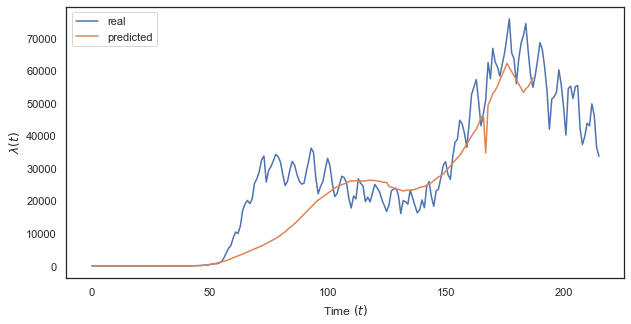

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_us[["index"]].to_numpy().reshape(-1, 1)
y_4 = y_1.reshape(-1) * final_data_us["S*I"] / 328000000**2 * t_.shape[0] # S(t) and I(t) are actually the densities

_ = plt.plot(ms_us_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_4, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

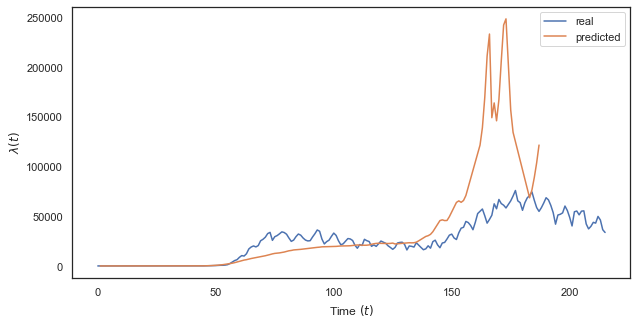

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_us[["index"]].to_numpy().reshape(-1, 1)
y_5 = y_2.reshape(-1) * final_data_us["S*I"] / 328000000**2 * t_.shape[0] # S(t) and I(t) are actually the densities

_ = plt.plot(ms_us_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_5, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

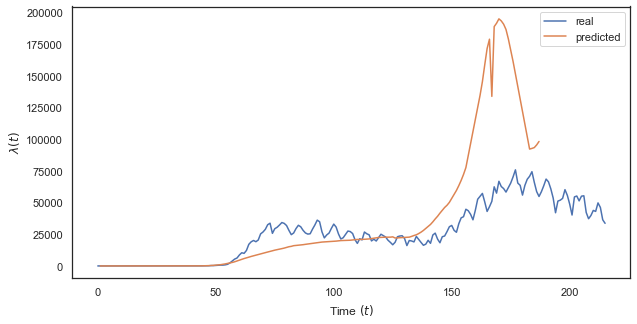

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_us[["index"]].to_numpy().reshape(-1, 1)
y_6 = y_3.reshape(-1) * final_data_us["S*I"] / 328000000**2 * t_.shape[0] # S(t) and I(t) are actually the densities

_ = plt.plot(ms_us_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_6, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

### Model 3: $\lambda(t) = \exp(f(S(t)I(t)))$

In [52]:
y = final_data_us[["ConfirmedChange"]].to_numpy()
X = final_data_us[["S*I"]].to_numpy()

y_scaler = preprocessing.StandardScaler().fit(y)
y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X)
X = x_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

y_train = y_train
y_test = y_test

X_train = X_train
X_test = X_test

In [53]:
MTRN = gpflow.kernels.Matern32()
k_mtrn = MTRN

print_summary(k_mtrn)

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k_slr = SE*LIN*RQ

print_summary(k_slr)

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


##### Kernel SE * LIN * RQ

In [54]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k_slr
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.8958207436383976
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.4099027434152132
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.8958207436383998
VGP.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.895820743638417
VGP.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,0.16409871456508396
VGP.kernel.kernels[2].alpha,Parameter,Softplus,,True,(),float64,0.03737849798474021
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.012806759510861274
VGP.q_mu,Parameter,Identity,,False,"(111, 1)",float64,[[1.05764019e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 111, 111)",float64,"[[[1.05348111e-01, 0.00000000e+00, 0.00000000e+00..."


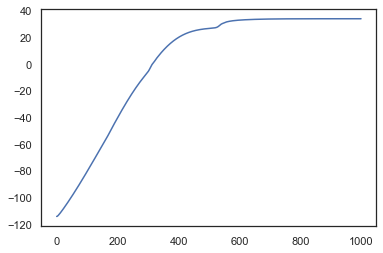

In [55]:
# ELBO
plt.plot(logf)

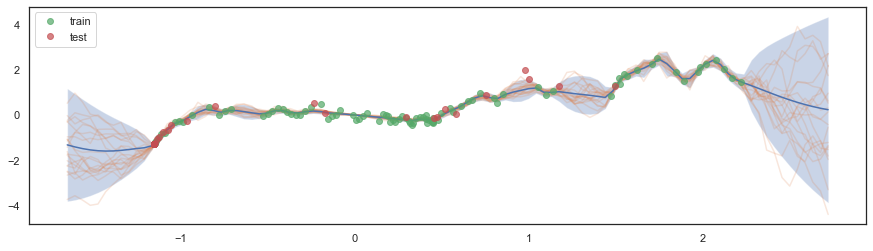

In [56]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [57]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.0038931442449262523, 'test', 0.008957696801503962)

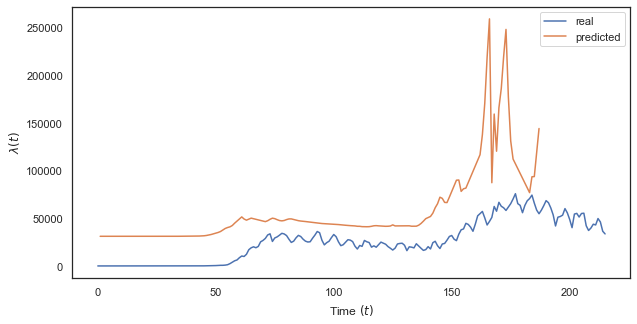

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_us[["index"]].to_numpy().reshape(-1, 1)
y_7 = y_scaler.inverse_transform(np.exp(m.predict_f(X)[0].numpy()))

_ = plt.plot(ms_us_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_7, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

##### Kernel Matern32

In [59]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k_mtrn
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.9798385482852413
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.20303608062754933
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.005952806586320698
VGP.q_mu,Parameter,Identity,,False,"(111, 1)",float64,[[1.03544404e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 111, 111)",float64,"[[[7.47054816e-02, 0.00000000e+00, 0.00000000e+00..."


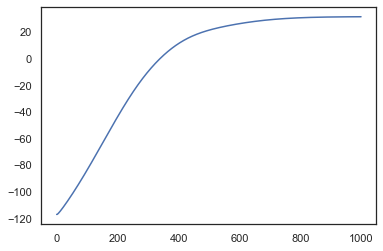

In [60]:
# ELBO
plt.plot(logf)

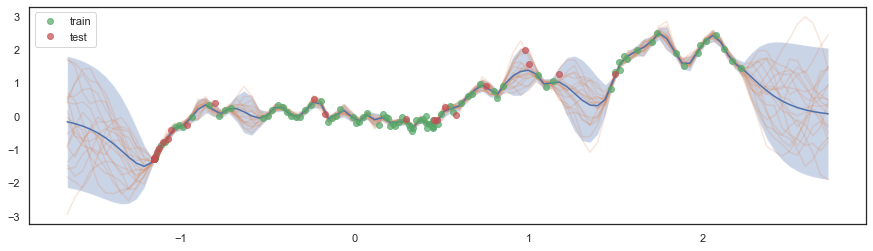

In [61]:
plot_prediction(X_train, y_train, m, X_test=X_test, Y_test=y_test)

In [62]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.002832039538307327, 'test', 0.011924591292634493)

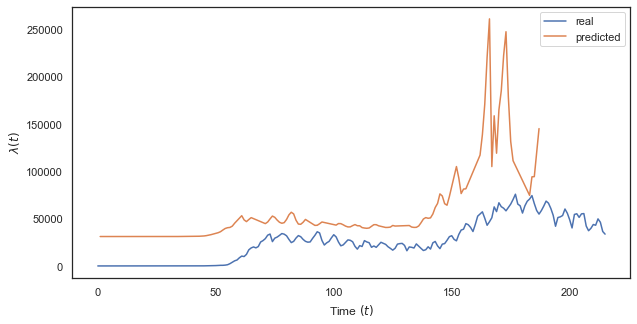

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))

t_ = final_data_us[["index"]].to_numpy().reshape(-1, 1)
y_8 = y_scaler.inverse_transform(np.exp(m.predict_f(X)[0].numpy()))

_ = plt.plot(ms_us_covid["ConfirmedChange"], label="real")
_ = plt.plot(t_, y_8, label="predicted")
_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend()

## New Models

In [64]:
final_data_us.head()

,Updated,Confirmed,ConfirmedChange,Deaths,Recovered,I,S,index,HOME,WORK,RECREATIONAL,OTHER,S*I
index,,,,,,,,,,,,,
1.0,2020-02-03,11.0,0.0,0.0,0.0,11.0,327999989.0,1.0,0.99,1.03,1.07,1.060000,3.608000e+09
2.0,2020-02-04,11.0,0.0,0.0,0.0,11.0,327999989.0,2.0,1.21,0.50,0.60,0.763333,3.608000e+09
3.0,2020-02-05,12.0,1.0,0.0,1.0,11.0,327999989.0,3.0,1.10,0.71,0.66,0.963333,3.608000e+09
4.0,2020-02-06,12.0,0.0,1.0,0.0,11.0,327999989.0,4.0,1.13,0.63,0.82,0.996667,3.608000e+09
5.0,2020-02-07,12.0,0.0,1.0,3.0,8.0,327999992.0,5.0,1.10,0.61,0.96,1.213333,2.624000e+09


In [65]:
final_data_us_cp = final_data_us.copy()


historical_window = 3

for i in range(1, historical_window+1):
    final_data_us_cp[f"I-{i}"] = final_data_us_cp["I"].shift(i)
final_data_us_cp.dropna(inplace=True)

y = final_data_us_cp[["ConfirmedChange"]].to_numpy()
X = final_data_us_cp[
    [f"I-{i}" for i in range(1, historical_window+1)] + \
    ["I", "S"]
].to_numpy()

y_scaler = preprocessing.StandardScaler().fit(y)
y = y_scaler.transform(y)

x_scaler = preprocessing.StandardScaler().fit(X)
X = x_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

y_train = y_train
y_test = y_test

X_train = X_train
X_test = X_test

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,1
Matern32.lengthscales,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Product.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[1].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].variance,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].lengthscales,Parameter,Softplus,,True,(),float64,1
Product.kernels[2].alpha,Parameter,Softplus,,True,(),float64,1


name,class,transform,prior,trainable,shape,dtype,value
Sum.kernels[0].variance,Parameter,Softplus,,True,(),float64,1
Sum.kernels[1].variance,Parameter,Softplus,,True,(),float64,1


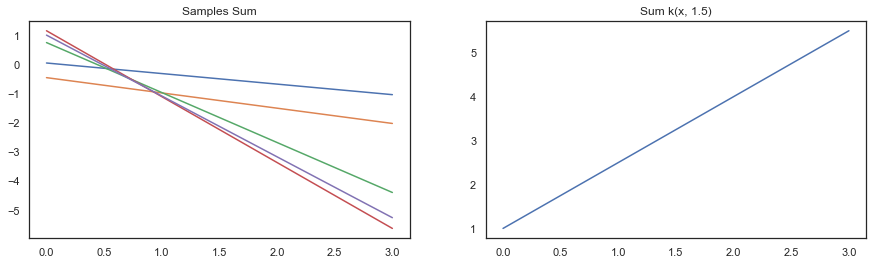

In [95]:
MTRN = gpflow.kernels.Matern32()
k_mtrn = MTRN

print_summary(k_mtrn)

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k_slr = SE*LIN*RQ

print_summary(k_slr)

#gpflow.kernels.Cosine(lengthscales=2.0) + 
k = (gpflow.kernels.Linear() + gpflow.kernels.Constant())
print_summary(k)

plot_kernel_sample(k, other=1.5)

In [96]:
m = gpflow.models.VGP(
    (X_train, y_train), 
    likelihood=gpflow.likelihoods.Gaussian(), 
    kernel=k
)

natgrad = NaturalGradient(gamma=1.0)
adam = tf.optimizers.Adam(0.01)

set_trainable(m.q_mu, False)
set_trainable(m.q_sqrt, False)

logf = []

for _ in range(ci_niter(1000)):
    adam.minimize(m.training_loss, m.trainable_variables)
    natgrad.minimize(m.training_loss, [(m.q_mu, m.q_sqrt)])   
    logf.append(m.elbo())
    
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.43966642951596613
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.09408984829268935
VGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.19800596640537582
VGP.q_mu,Parameter,Identity,,False,"(108, 1)",float64,[[-3.54836239e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 108, 108)",float64,"[[[1.05193062e-01, 0.00000000e+00, 0.00000000e+00..."


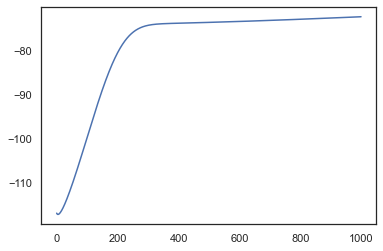

In [97]:
# ELBO
plt.plot(logf)

In [98]:
"train", np.mean(m.predict_f(X_train)[1]), "test", np.mean(m.predict_f(X_test)[1])

('train', 0.007656803854221168, 'test', 0.00785417820984603)

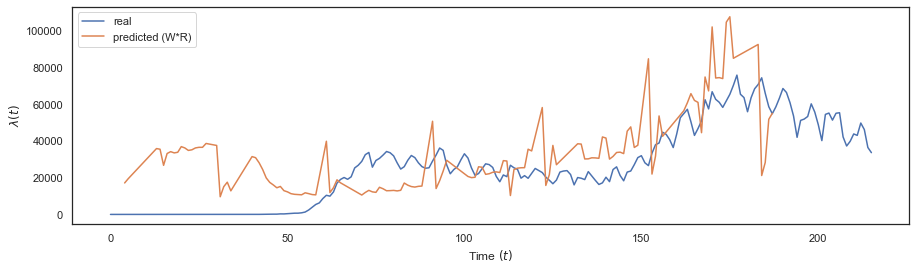

In [101]:
fig, ax = plt.subplots(figsize=(15, 4))

t_ = final_data_us_cp[["index"]].to_numpy().reshape(-1)

_ = plt.plot(ms_us_covid["ConfirmedChange"], label="real")

y_9 = y_scaler.inverse_transform(np.exp(m.predict_f(X)[0].numpy())).reshape(-1) * \
        (final_data_us_cp["WORK"] * final_data_us_cp["RECREATIONAL"])
_ = plt.plot(t_, y_9, alpha=1, label="predicted (W*R)")

_ = plt.ylabel("$\lambda(t)$")
_ = plt.xlabel("Time $(t)$")
_ = plt.legend(loc="upper left")